# TO DO
* transforms

In [1]:
from torchvision import datasets, transforms, utils
import torch
from torch.utils.data import random_split, DataLoader
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
    
#     'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# }

data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
data_dir = '/storage/data/vinted'

clothes_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)
    
clothes_dataset.classes

['coat', 'dress', 'jeans']

In [4]:
clothes_train, clothes_val = random_split(clothes_dataset, [480, 120])

In [5]:
train_loader = DataLoader(clothes_train, batch_size=32, num_workers=8)
val_loader = DataLoader(clothes_val, batch_size=32, num_workers=8)

In [6]:
# batch x shape
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [7]:
# batch y shape
next(iter(train_loader))[1].shape

torch.Size([32])

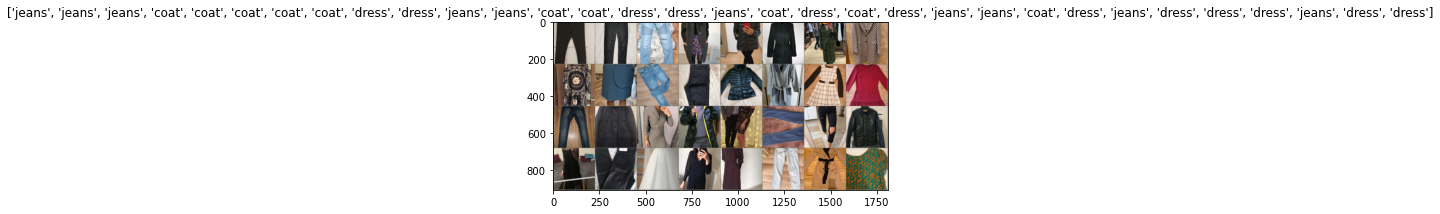

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = utils.make_grid(inputs)

class_names = clothes_dataset.classes

imshow(out, title=[class_names[x] for x in classes])

In [9]:
class ImageClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.train_acc = pl.metrics.Accuracy()
        self.valid_acc = pl.metrics.Accuracy()
        
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, 3, padding=1)
        
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4_bn = nn.BatchNorm2d(512)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.fc1_bn = nn.BatchNorm1d(1024)
        self.pool = nn.MaxPool2d(2, 2)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(512 * 28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = self.pool(F.relu(self.conv5_bn(self.conv5(x))))
        
        x = x.view(-1, 512 * 28 * 28)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.fc2(x)
        
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.dropout1(self.pool(F.relu(self.conv2(x))))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
#         x = self.dropout1(self.pool(F.relu(self.conv5(x))))
        
#         x = x.view(-1, 512 * 7 * 7)
#         x = self.dropout2(F.relu(self.fc1(x)))
#         x = self.fc2(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.train_acc(y_hat, y)
        self.log('train_acc', self.train_acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', val_loss, prog_bar=True)
        self.valid_acc(y_hat, y)
        self.log('valid_acc', self.valid_acc, prog_bar=True)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [10]:
model = ImageClassifier()

In [11]:
trainer = pl.Trainer(gpus=1, max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [12]:
trainer.fit(model, train_loader, val_loader)


   | Name      | Type        | Params
-------------------------------------------
0  | train_acc | Accuracy    | 0     
1  | valid_acc | Accuracy    | 0     
2  | conv1     | Conv2d      | 1 K   
3  | conv2     | Conv2d      | 73 K  
4  | conv3     | Conv2d      | 295 K 
5  | conv4     | Conv2d      | 1 M   
6  | conv5     | Conv2d      | 2 M   
7  | conv1_bn  | BatchNorm2d | 128   
8  | conv2_bn  | BatchNorm2d | 256   
9  | conv3_bn  | BatchNorm2d | 512   
10 | conv4_bn  | BatchNorm2d | 1 K   
11 | conv5_bn  | BatchNorm2d | 1 K   
12 | fc1_bn    | BatchNorm1d | 2 K   
13 | pool      | MaxPool2d   | 0     
14 | fc1       | Linear      | 411 M 
15 | fc2       | Linear      | 3 K   


1

### CNN:

loss=0.630, v_num=32, train_acc=0.625, val_loss=0.844, valid_acc=0.633

loss=0.775, v_num=37, train_acc=0.688, val_loss=0.938, valid_acc=0.5

loss=0.858, v_num=42, train_acc=0.594, val_loss=0.923, valid_acc=0.575

loss=0.149, v_num=52, train_acc=0.938, val_loss=1.11, valid_acc=0.633

In [13]:
# import shutil
# shutil.rmtree('/storage/data/vinted/.ipynb_checkpoints')

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to('cpu')
            labels = labels.to('cpu')

            outputs = model(inputs)
            values, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, {values[j]}, actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

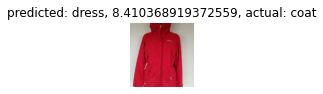

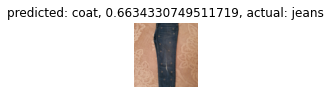

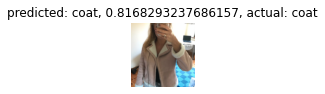

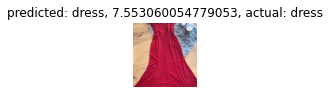

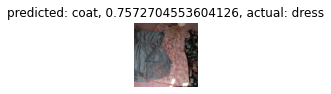

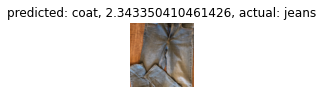

In [15]:
visualize_model(model)